In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
article_date = '2018-12-21'

In [6]:
# Import required packages
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib as mpl
from faculty import datasets

from models.article import Article

from newsapi import NewsApiClient


%matplotlib inline

In [7]:
def load_article_from_datasets(foo):
    articles = []
    with datasets.open(f'/input/article_content/{foo}.csv') as f:
        df = pd.read_csv(f, sep='\t', encoding='utf-8')
    for row in df.iterrows():
        articles.append(Article(
            row[1]['article_url'], 
            row[1]['article_title'],
            row[1]['article_description'],
            row[1]['source_id'],
            row[1]['published_at'],
            row[1]['article_uuid'],
            row[1]['named_entities'],
            None,
            row[1]['raw_content']
        ))
    return articles

In [8]:
articles = load_article_from_datasets(article_date)

In [9]:
# Create tf_idf matrix from articles
named_entities_list = list(map(lambda x: ' '.join(x.named_entities), articles))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(named_entities_list)
print(tfidf_matrix.shape)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [9]:
# Run k-means clustering on tf_idf matrix
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 29.7 s, sys: 1.54 s, total: 31.2 s
Wall time: 8.12 s


In [10]:
def print_cluster_terms():
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names()
    for i in range(num_clusters):
        print("Cluster %d:" % i),
        cluster_terms = []
        for ind in order_centroids[i, :10]:
             cluster_terms.append(terms[ind])
        print(' '.join(cluster_terms))
        print
print_cluster_terms()

Top terms per cluster:
Cluster 0:
city mourinho chelsea manchester arsenal liverpool guardiola united pga monsanto
Cluster 1:
new york canada fredericton canadian german ap johnson mexico france
Cluster 2:
ap reuters britain county uk london united university american british
Cluster 3:
china chinese beijing united states iran reuters xinjiang japan india
Cluster 4:
trump house russia donald russian fraser white states united washington
Cluster 5:
korea north korean south qualcomm kim taiwan pyongyang trade taiwanese
Cluster 6:
turkey turkish erdogan trump ankara tayyip states european united washington


In [11]:
clusters = km.predict(tfidf_matrix)

In [12]:
cluster_article_map = {}
cluster_article_title_map = {}
for i in range(len(articles)):
    cluster = clusters[i]
    article = articles[i]
    if cluster in cluster_article_map.keys():
        cluster_article_map[cluster].append(article)
    else:
        cluster_article_map[cluster] = [article]
    if cluster in cluster_article_title_map.keys():
        cluster_article_title_map[cluster].append(article.title)
    else:
        cluster_article_title_map[cluster] = [article.title]

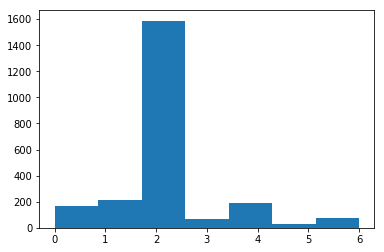

In [13]:
plt.hist(km.labels_, bins=num_clusters)
plt.show()

In [14]:
dist = 1 - cosine_similarity(tfidf_matrix)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

titles = list(map(lambda x: x.title, articles))
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {
    0: '#FFE981',
    1: '#FF6748',
    2: '#BBDED6',
    3: '#BEEB9F',
    4: '#F8B595',
    5: '#F67280',
    6: '#C06C84',
    7: '#6C5B7C',
    8: '#FFB6B9',
    9: '#FF9797',
}

#set up cluster names using a dict
cluster_names = {
    0: 'A', 
    1: 'B', 
    2: 'C', 
    3: 'D', 
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
}

In [ ]:
%matplotlib inline 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(
        group.x,
        group.y,
        marker='o',
        linestyle='',
        ms=12, 
        label=cluster_names[name],
        color=cluster_colors[name], 
        mec='none'
    )
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

In [1]:
print_cluster_terms()

NameError: name 'print_cluster_terms' is not defined